### 第一步：準備 YOLO 模型

在使用 YOLO 模型時，應該使用 **預訓練權重（`.pt`）** 進行推理或訓練優化，而 **`.yaml` 檔案** 是用來定義模型結構和訓練數據集的配置。

具體來說：
- **`.pt` 文件** 是你已經訓練好的模型權重，包含了模型參數，用來進行推理、微調等任務。這是進行剪枝、量化等優化的主要對象。
- **`.yaml` 文件** 是 YOLO 的配置檔案，主要用來定義模型架構（如 YOLOv5 的不同大小版本）以及訓練時使用的數據集、類別等。

---

In [ ]:
import torch

# 加載你自己訓練的 YOLO 模型
model = torch.hub.load('ultralytics/yolov5', 'custom', path=r'/app/yolov5-master/runs/train/exp2/weights/best.pt')

**在模型優化中，我們可以採取以下幾個技術步驟來提升效能：**

### 第二步：模型剪枝 (Pruning)
**目的：** 
剪枝的目的是移除不必要的神經元或卷積核，減少模型的參數量，以降低推理的計算成本和記憶體佔用，從而提升推理效能，特別適合資源有限的設備。

### 操作步驟：
1. **瞭解剪枝技術：** 剪枝會根據某些策略移除重要性較低的參數。常見的策略包括：基於稀疏性的剪枝（如修剪權重值接近零的參數）或者基於效能的剪枝（如計算每個參數對最終預測結果的貢獻）。
2. **選擇合適的剪枝工具：** 可以使用 PyTorch 或第三方庫（例如 Torch-Pruning 或 AutoML 工具）來進行模型剪枝。
3. **實際代碼範例：**

**為什麼這麼做？**
剪枝能夠有效減少模型的冗餘參數，尤其是在訓練過程中可能導致過擬合的部分。透過剪枝，你可以讓模型在推理時更快、資源佔用更少，適合應用在嵌入式系統或雲端上的大規模佈署。

這一步完成後，請測試模型的效能變化，看看在削減部分參數後是否還能保持準確率，並檢查推理速度是否提升。

---

In [ ]:
import torch_pruning as tp

# 設定模型剪枝
strategy = tp.strategy.L1Strategy()  # 基於 L1 正則化進行剪枝
model = model.eval()  # 將模型設為評估模式

# 確定要剪枝的層，例如卷積層
layer_to_prune = model.model[4]  # 假設你想剪枝第 4 層卷積層
importance = strategy(layer_to_prune.weight)  # 計算該層的重要性

# 剪枝層
pruner = tp.pruner.MagnitudePruner(model, [layer_to_prune], importance)
pruner.step()  # 執行剪枝

# 保存剪枝後的模型
torch.save(model.state_dict(), 'Day28_pruned_model.pth')
print("剪枝後的模型已保存到 'pruned_model.pth'")

**在 PyTorch 中，訓練完的模型通常保存為 `.pth` 或 `.pt` 的文件格式。**

### `.pth` 副檔名的來源與意圖
1. **文件格式與 Python 兼容性**：
   `.pth` 文件本質上是一個 Python 字典（`dict`），其中包含了模型的所有參數（權重和偏置），這些參數通常是以 `torch.Tensor` 的形式存儲。`.pth` 是 PyTorch 的文件格式，它方便與 Python 的序列化方法相結合，如 `pickle`，使模型的保存和加載變得簡單直觀。

2. **PyTorch 社區的慣例**：
   `.pth` 和 `.pt` 都是 PyTorch 社區中普遍使用的擴展名。這些擴展名的選擇並沒有特定的技術要求，主要是一種慣例。社區內普遍使用 `.pth`，所以大家就繼續使用這種命名方式。

3. **模型權重保存**：
   在訓練完成後，通常需要保存模型的權重（模型參數）以便於後續的推理使用或者微調。`.pth` 文件中存儲的是模型的權重矩陣，這些權重經過序列化後可以保存為磁碟文件，並可以在其他環境中載入，無需重新訓練。

### `.pth` 和 `.pt` 的區別
- `.pth` 和 `.pt` 在技術層面上並沒有區別，它們都是 PyTorch 的文件格式，可以用於保存模型權重或者完整的模型。
- 兩者都可以通過 `torch.save()` 保存，並通過 `torch.load()` 重新加載。
- `.pth` 通常是社區中的首選擴展名，而 `.pt` 也可以用來表示模型，但有些開發者更傾向於使用 `.pt` 來表示可直接部署的推理模型（checkpoint）。

### 總結
`.pth` 是 PyTorch 中保存模型權重的常用擴展名，其背後沒有特殊的技術原因，而更多的是社區的一種慣例。它方便用於保存和載入訓練好的模型，以便進行推理、微調或者繼續訓練。

---

### **測試剪枝前模型效能：測試推理速度**

In [ ]:
import time
import torch

# 載入剪枝前的模型（假設名稱為 original_model）
original_model = torch.hub.load('ultralytics/yolov5', 'custom', path=r'/app/yolov5-master/runs/train/exp2/weights/best.pt')
original_model.eval()  # 設定模型為評估模式

# 測試用的圖像數據（可以使用一張或多張測試圖像）
img = torch.randn(1, 3, 640, 640)  # 模擬一張 640x640 大小的隨機圖像

# 測試推理速度
start_time = time.time()
with torch.no_grad():  # 禁止梯度計算來加速推理
    for _ in range(100):  # 假設我們測試 100 次推理
        _ = original_model(img) # 進行推理
end_time = time.time()  # 計算推理時間

average_inference_time = (end_time - start_time) / 100
print(f"剪枝前模型的平均推理時間: {average_inference_time:.4f} 秒")

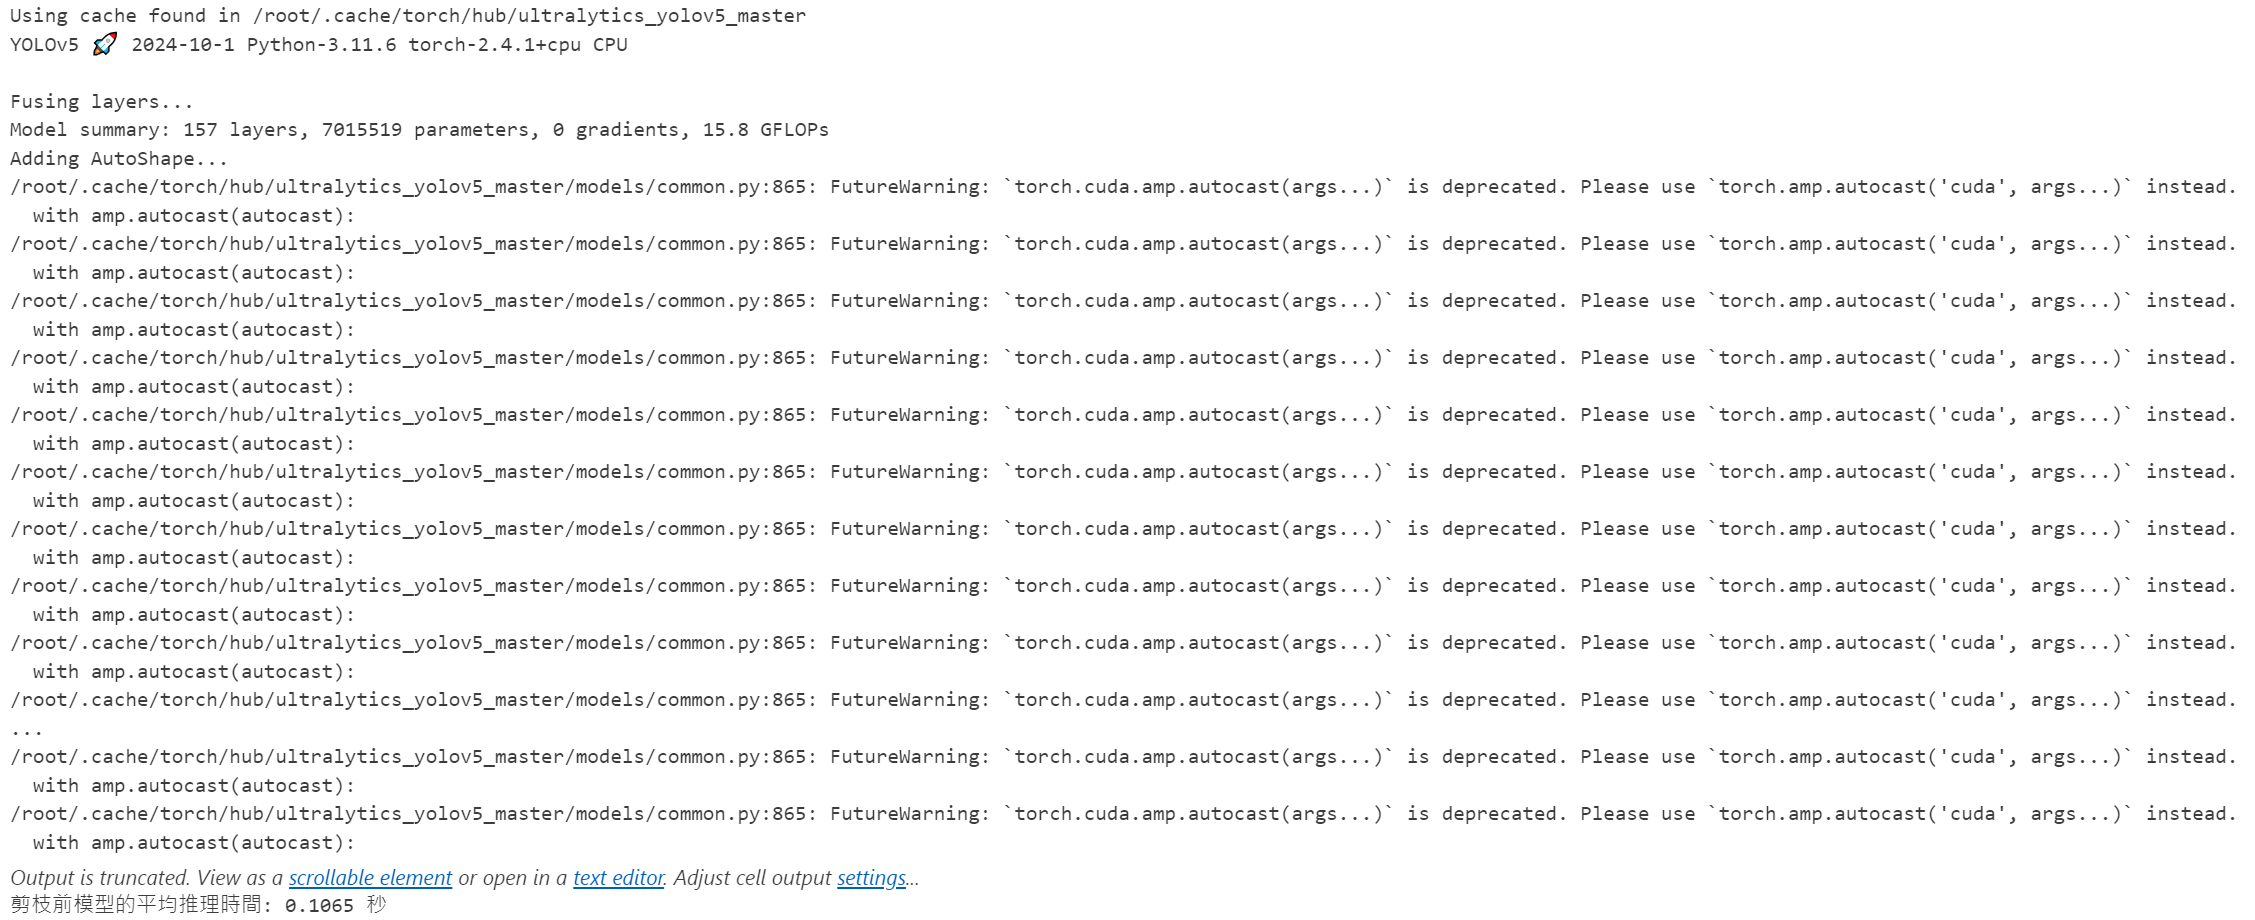

### **測試剪枝後模型效能：測試推理速度**

剪枝的目的是加速模型的推理，因此一個重要的效能指標就是推理速度。我們可以通過計算模型在一組測試圖像上的平均推理時間來評估。

### 剪枝後模型的載入流程
1. **模型架構的載入**：
   在程式碼中，你首先使用以下代碼載入了 YOLO 模型架構：
   ```python
   pruned_model = torch.hub.load('ultralytics/yolov5', 'custom', path=r'/app/yolov5-master/runs/train/exp2/weights/best.pt')
   ```
   這一步的目的主要是載入 YOLO 的模型結構，這個結構不會因為剪枝而變化。載入的模型包括所有卷積層、線性層等結構。

2. **載入剪枝後的權重**：
   剪枝之後的權重保存在 `pruned_model.pth` 中，你可以直接載入這些權重：
   ```python
   pruned_model.load_state_dict(torch.load('/app/yolov5-master/pruned_model.pth'))
   ```
   這一步是將剪枝後的權重加載到模型中。這些權重已經經過剪枝，因此只需載入這個 `.pth` 文件即可。原始模型權重並不需要在這裡重新載入。

3. **評估模式的設置**：
   最後，將模型設置為評估模式：
   ```python
   pruned_model.eval()
   ```
   這樣可以確保模型在推理過程中禁用掉訓練模式下的操作（例如 dropout），從而獲得穩定的推理結果。

### 正確的操作流程
- **首先載入模型架構**，這樣你就擁有了 YOLO 的網絡結構。
- **然後載入剪枝後的權重**，這些權重已經包含了剪枝之後的模型的狀態。

在你的剪枝後模型的程式碼中，應該根據需求來選擇載入官方的 YOLOv5 權重還是你自己訓練的權重：

### 1. 載入官方權重 vs. 自己訓練的權重
- **官方權重**：當你使用官方的預訓練權重時，這些權重是基於 COCO 或其他通用數據集訓練的，具有良好的泛化能力，適合一般的物件偵測任務。使用官方權重可以直接獲得一個訓練良好的模型結構和參數。
  
  ```python
  model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
  ```
  上述程式碼會載入 YOLOv5s（最小型的版本）預訓練模型，這些模型結構固定，適合標準的物件偵測應用。

- **自己訓練的權重**：如果你針對特定的任務（如自定義數據集）進行過訓練，則應該載入你自己訓練的模型權重。這樣可以保持模型結構和參數的專用性，適合你的特定應用場景。

  ```python
  model = torch.hub.load('ultralytics/yolov5', 'custom', path=r'/app/yolov5-master/runs/train/exp2/weights/best.pt')
  ```
  這會載入你自己訓練的 YOLO 模型權重，這些權重已經針對你的數據進行過調整，更加適合你的任務。

### 2. YOLO 網絡結構的影響
YOLO 的網絡結構在以下情況下可能會有所不同：
- **不同的 YOLO 版本**：例如 YOLOv5 提供了不同大小的模型 (`yolov5s`, `yolov5m`, `yolov5l`, `yolov5x`)，它們的網絡結構不同，從較小的、適合快速推理的模型到較大的、更精確的模型。
- **自定義的變更**：如果你在訓練過程中修改了 YOLO 的配置文件（例如更改卷積層數量、通道數等），那麼網絡結構也會隨之改變。這些更改可能是為了更好地適應特定的數據集或硬件資源。

在你訓練自己的模型時，如果你只是用官方提供的 YOLOv5 結構並且只改變了數據集，那麼網絡結構並不會變化，你可以載入相同的模型架構。但如果你在訓練中對 YOLO 的結構進行了修改（例如調整層數、通道數等），那麼網絡結構就會有所不同。

### 建議
- **載入自己訓練的模型權重**：因為剪枝是基於你自己訓練的模型進行的，所以應該先載入你自己訓練好的模型權重，這樣模型的結構和權重才能匹配。
- **保持一致的模型架構**：如果你使用了自定義的模型結構，那麼在剪枝後測試時，一定要保持相同的架構，否則模型的權重和結構將不匹配。

因此，對於剪枝後的模型，你應該首先載入你自己訓練的權重（在 `best.pt` 中），這樣可以確保模型架構正確且適應你的特定數據集。隨後再載入剪枝後的模型權重（`pruned_model.pth`），進行剪枝後的測試和部署。

In [ ]:
import time
import torch

# 載入剪枝後的模型
pruned_model = torch.hub.load('ultralytics/yolov5', 'custom', path=r'/app/yolov5-master/runs/train/exp2/weights/best.pt')
pruned_model.load_state_dict(torch.load('/app/yolov5-master/pruned_model.pth'))
pruned_model.eval()  # 設定模型為評估模式

# 測試用的圖像數據（可以使用一張或多張測試圖像）
img = torch.randn(1, 3, 640, 640)  # 模擬一張 640x640 大小的隨機圖像

# 測試推理速度
start_time = time.time()
with torch.no_grad():  # 禁止梯度計算來加速推理
    for _ in range(100):  # 假設我們測試 100 次推理
        _ = pruned_model(img)  # 進行推理
end_time = time.time()  # 計算推理時間

average_inference_time = (end_time - start_time) / 100
print(f"剪枝後模型的平均推理時間: {average_inference_time:.4f} 秒")

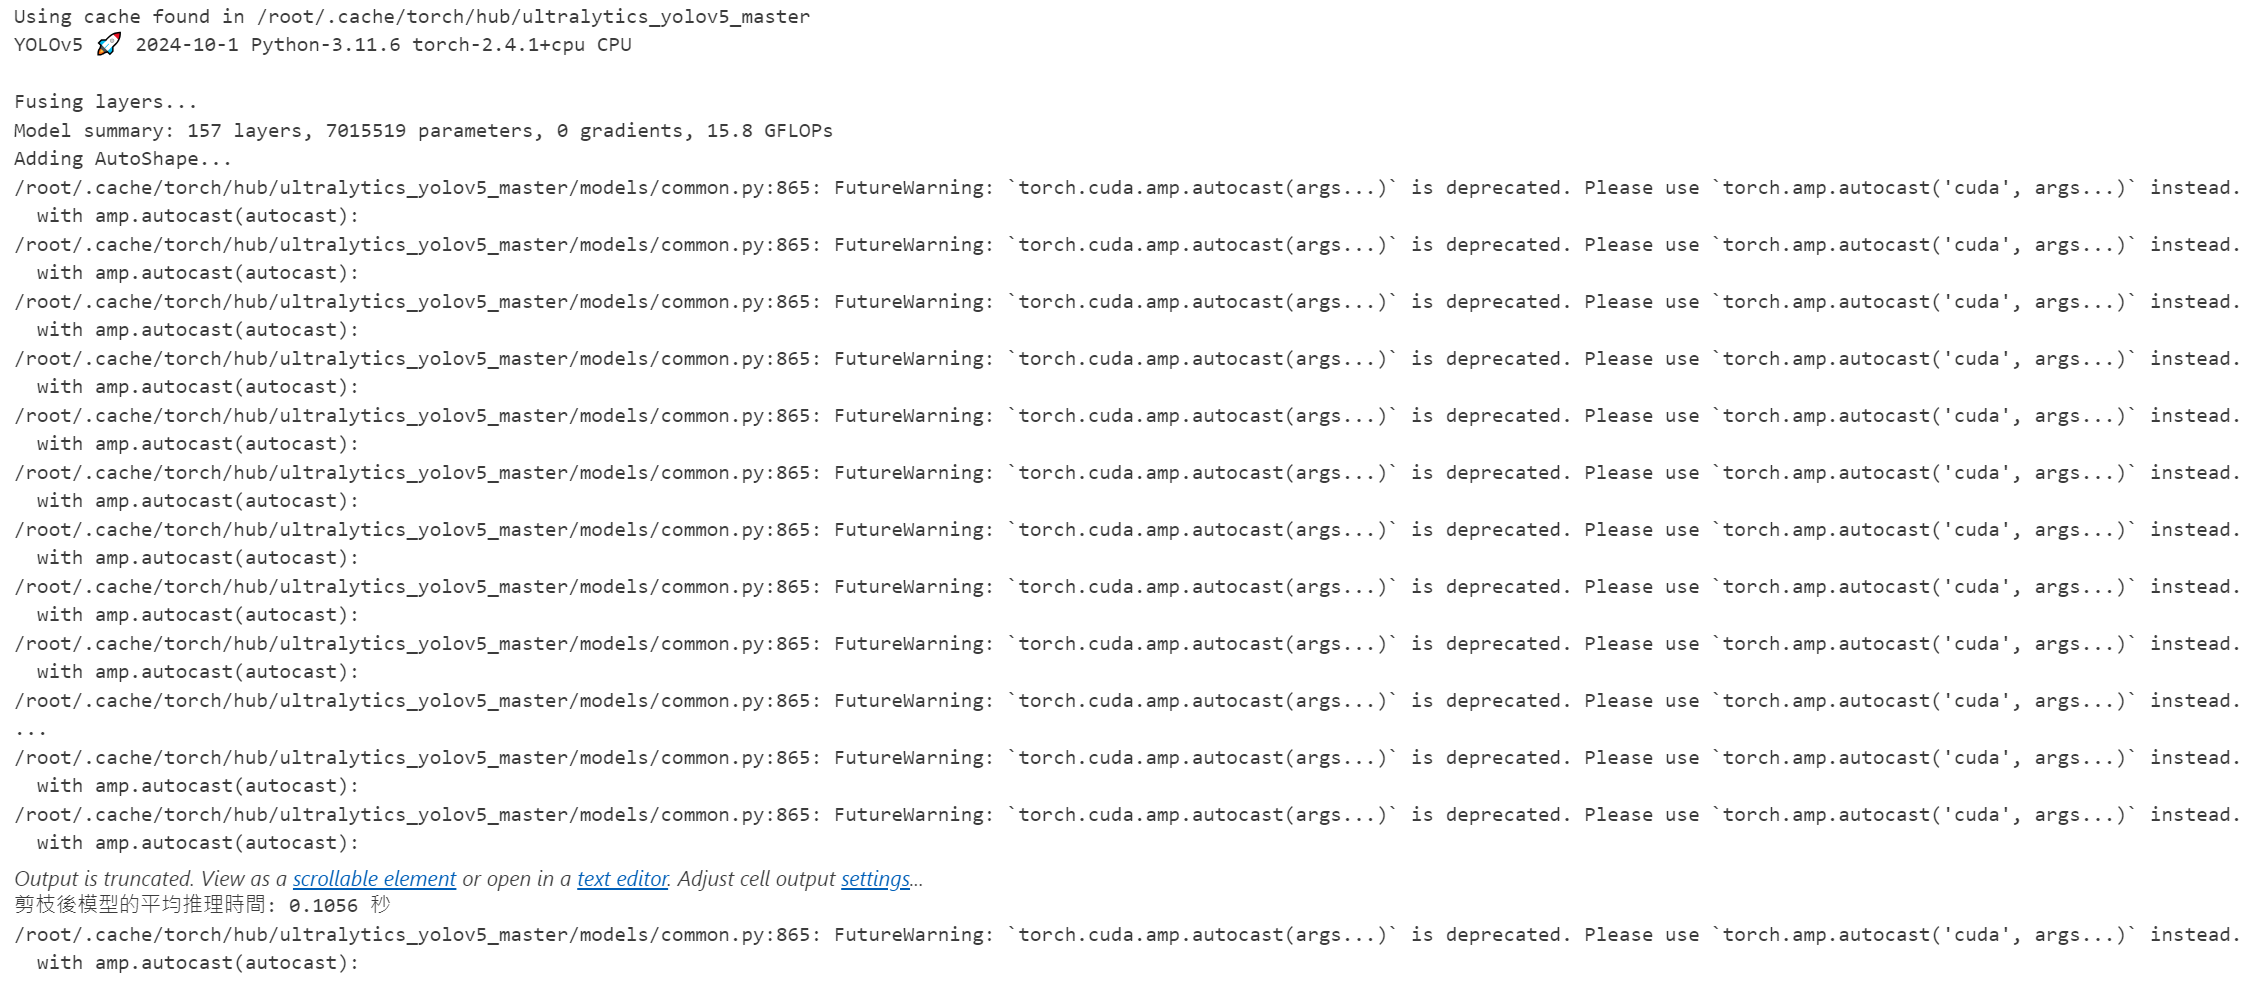

---

### 範例：使用 CIFAR-10 和 VGG16 模型
將基於 PyTorch 使用 CIFAR-10 數據集和 VGG16 模型，並在剪枝後測試模型的準確性。

### **載入 CIFAR-10 數據集**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 定義數據增強和預處理
transform = transforms.Compose([
    transforms.ToTensor(),  # 將圖像轉為 Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 標準化
])

# 載入 CIFAR-10 測試數據集
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### **定義 VGG16 模型**

In [ ]:
import torchvision.models as models

# 載入 VGG16 模型
model = models.vgg16(pretrained=True)  # 使用預訓練模型
model.classifier[6] = nn.Linear(4096, 10)  # 修改輸出層，使其適合 CIFAR-10 (10 個類別)
model.eval()  # 設定為評估模式

### **測試剪枝前模型效能：測試模型準確性**

In [ ]:
correct = 0 # 正確的圖像數
total = 0 # 圖像的總數

# 禁止梯度計算來加速推理
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)  # 模型推理
        _, predicted = torch.max(outputs, 1)  # 獲取預測的類別
        total += labels.size(0) # 累加圖像的總數
        correct += (predicted == labels).sum().item() # 累加預測正確的圖像數

# 計算準確率
accuracy = correct / total
print(f"剪枝前模型的準確率: {accuracy:.4f}")

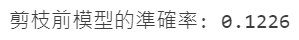

模型的準確率為 12.26%。

### **測試剪枝後模型效能：測試模型準確性**

剪枝可能會影響模型的準確性，因此需要通過測試集來檢測模型的準確性。我們可以通過比較剪枝前後模型的準確率來評估這一點。

### **剪枝模型**

In [10]:
import torch.nn.utils.prune as prune

# 剪枝某些層，例如 VGG16 的某個卷積層
for module in model.features:
    if isinstance(module, nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.3)  # 剪掉 30% 的權重

### **測試剪枝後模型的準確性**

In [ ]:
correct = 0 # 正確的圖像數
total = 0 # 圖像的總數

# 禁止梯度計算來加速推理
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)  # 剪枝後模型推理
        _, predicted = torch.max(outputs, 1)  # 獲取預測的類別
        total += labels.size(0) # 累加圖像的總數
        correct += (predicted == labels).sum().item() # 累加預測正確的圖像數

# 計算準確率
accuracy = correct / total
print(f"剪枝後模型的準確率: {accuracy:.4f}")

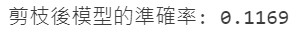

模型的準確率為 11.69%

---

### 測試內存的目的
這段程式碼的主要目的是**測試剪枝前模型在空閒狀態下的內存佔用**，而不是進行推理或計算。它的測試重點在於確認模型本身（包括模型參數、架構等）對系統內存的影響。具體來說：

1. **GPU 內存使用情況**：
   - 使用 `torch.cuda.memory_allocated()` 來查看當前 GPU 被佔用的內存。
   - 在這裡，`torch.cuda.empty_cache()` 會清空 GPU 的緩存，確保測試得到的是模型本身佔用的內存，而不是被緩存的其他數據所占用。

2. **CPU 內存使用情況**：
   - 使用 `psutil.Process()` 創建一個表示當前 Python 進程的對象，然後使用 `memory_info().rss` 來查看當前進程的**駐留集大小**（RSS），這代表了當前進程使用的物理內存量。
   - 在這裡查看的是 CPU 的內存佔用情況，主要是模型權重和結構在加載到 CPU 中所占用的內存。

### **測試剪枝前模型效能：測試內存使用情況**

In [ ]:
import torch
import psutil

# 載入剪枝前的模型
original_model = torch.hub.load('ultralytics/yolov5', 'custom', path=r'/app/yolov5-master/runs/train/exp2/weights/best.pt')
original_model.eval()  # 設定模型為評估模式

# 查看 GPU 內存使用情況
if torch.cuda.is_available():
    torch.cuda.empty_cache()  # 清空 GPU 的緩存，以確保測試的準確性
    print(f"剪枝前的 GPU 內存佔用: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB")

# 查看 CPU 內存使用情況
process = psutil.Process()
print(f"剪枝前的 CPU 內存佔用: {process.memory_info().rss / 1024 ** 2:.2f} MB")

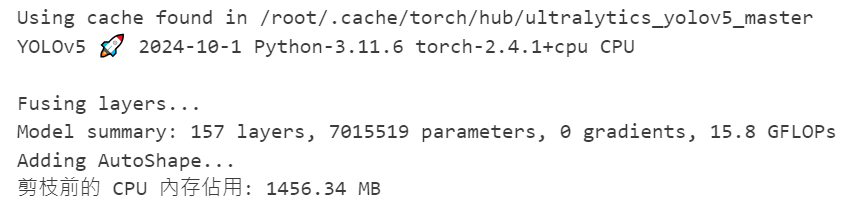

### **測試剪枝後模型效能：測試內存使用情況**

可以通過監控模型的內存佔用情況來檢查剪枝的效果。在 PyTorch 中，我們可以使用 `torch.cuda.memory_allocated()` 來檢查 GPU 內存的佔用，或者通過 `psutil` 庫來監控 CPU 內存。

In [ ]:
import torch
import psutil

# 載入剪枝後的模型
pruned_model = torch.hub.load('ultralytics/yolov5', 'custom', path=r'/app/yolov5-master/runs/train/exp2/weights/best.pt')
pruned_model.load_state_dict(torch.load('/app/yolov5-master/pruned_model.pth'))
pruned_model.eval()  # 設定模型為評估模式

# 查看 GPU 內存使用情況
if torch.cuda.is_available():
    torch.cuda.empty_cache()  # 清空 GPU 緩存，以獲得更準確的內存測量
    _ = pruned_model(torch.randn(1, 3, 640, 640).cuda())  # 確保模型被加載到 GPU 並執行一次推理
    print(f"剪枝後的 GPU 內存佔用: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB")

# 查看 CPU 內存使用情況
process = psutil.Process()
print(f"剪枝後的 CPU 內存佔用: {process.memory_info().rss / 1024 ** 2:.2f} MB")

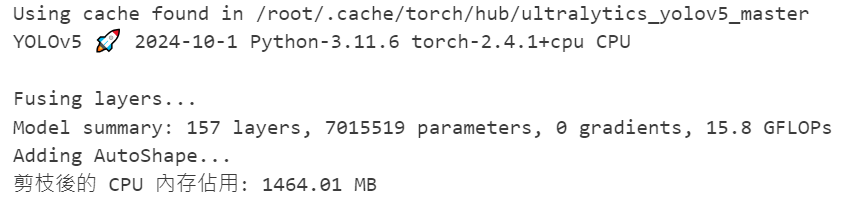

---

### 第三步：量化（Quantization）

在測試完剪枝後模型的效能之後，下一步你可以考慮進行 **量化（Quantization）**，這是一種常見的優化技術，可以進一步減少模型的計算量和內存佔用，而不會對模型的準確性造成太大的影響。

### 量化的概念
量化是一種將模型參數（通常是浮點數）轉換為較低精度（例如整數）的技術，從而減少模型的存儲空間並加速推理過程。常見的量化技術包括 **靜態量化（Post-Training Quantization, PTQ）** 和 **動態量化（Dynamic Quantization）**。


### 動態量化的特點：
- **應用場景：** 動態量化主要用來減少推理時的計算量和記憶體佔用，特別適合在 **CPU** 上運行的模型。常見用於全連接層（如 `torch.nn.Linear`）的量化，適合推理場景。
- **工作原理：** 動態量化會在推理時將模型的權重量化（通常轉換為 8 位整數），但輸入資料仍然保持浮點格式。在推理過程中，模型的權重會動態從浮點格式轉換為量化格式。
- **使用方法：** 代碼中的 `torch.quantization.quantize_dynamic()` 就是典型的動態量化方法，主要對全連接層進行量化，這有助於減少推理的資源佔用和時間。

```python
quantized_model = torch.quantization.quantize_dynamic(
    model,  # 目標模型
    {torch.nn.Linear},  # 只對全連接層進行量化
    dtype=torch.qint8  # 使用8位量化
)
```

### **動態量化 vs 靜態量化：**
1. **動態量化（Dynamic Quantization）：**
   - 只對模型的權重進行量化，而輸入和中間激活值依然保持浮點格式。
   - 優點是使用簡單，可以直接對已經訓練好的模型應用，不需要重新訓練或準備額外的數據。
   - 主要適用於 **CPU** 上推理速度的提升。

2. **靜態量化（Static Quantization）：**
   - 靜態量化不僅量化模型的權重，還量化激活值（即中間的輸出），因此可以帶來更大的效能提升。
   - 靜態量化需要在量化之前使用一些校準數據（calibration data）來確定輸入和激活的量化範圍。
   - 需要額外的校準步驟，這通常需要一些樣本來計算激活值的範圍。

### 動態量化的優勢：
- **簡單易用：** 不需要額外的校準數據，也不需要重新訓練，適合對已訓練完的模型進行部署。
- **推理加速：** 能顯著減少推理時的計算量，特別是在 **CPU** 上有明顯的效能提升。

### 靜態量化的應用場景：
如果你對推理效能的要求極高，或者希望將模型存儲空間最小化，靜態量化會比動態量化更有效。不過，它需要額外的數據準備（校準數據）以及更多的配置工作。

總結：當前實現的量化屬於 **動態量化**，適合大多數場景，特別是對已經訓練完成的模型，不需要重新訓練或校準數據的情況。如果你對性能有更高的需求，或者需要在資源受限的設備上部署模型，可以進一步研究 **靜態量化** 或 **混合精度訓練**。

### **動態量化（Dynamic Quantization）測試**

#### **可以將量化前後的模型測試分成兩個獨立的部分，分別進行量化前的推理測試和量化後的推理測試。**

#### 1. 量化前的推理時間與效能測驗：

In [ ]:
import torch
import time

# 定義一個函數來測試模型的推理時間
def test_inference_time(model, img, iterations=100):
    start_time = time.time()  # 記錄開始時間
    with torch.no_grad():  # 禁止梯度計算來加速推理
        for _ in range(iterations):  # 假設我們測試 100 次推理
            _ = model(img)  # 進行推理
    end_time = time.time()  # 記錄結束時間
    return (end_time - start_time) / iterations  # 計算平均推理時間

# 模擬一張 640x640 大小的隨機圖像
img = torch.randn(1, 3, 640, 640)

# 創建模型結構，然後加載權重
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/app/yolov5-master/runs/train/exp2/weights/best.pt')
model.eval()  # 設定模型為評估模式

# 測試模型的推理時間（量化前）
inference_time_before = test_inference_time(model, img)
print(f"量化前推理时间: {inference_time_before:.6f} 秒")

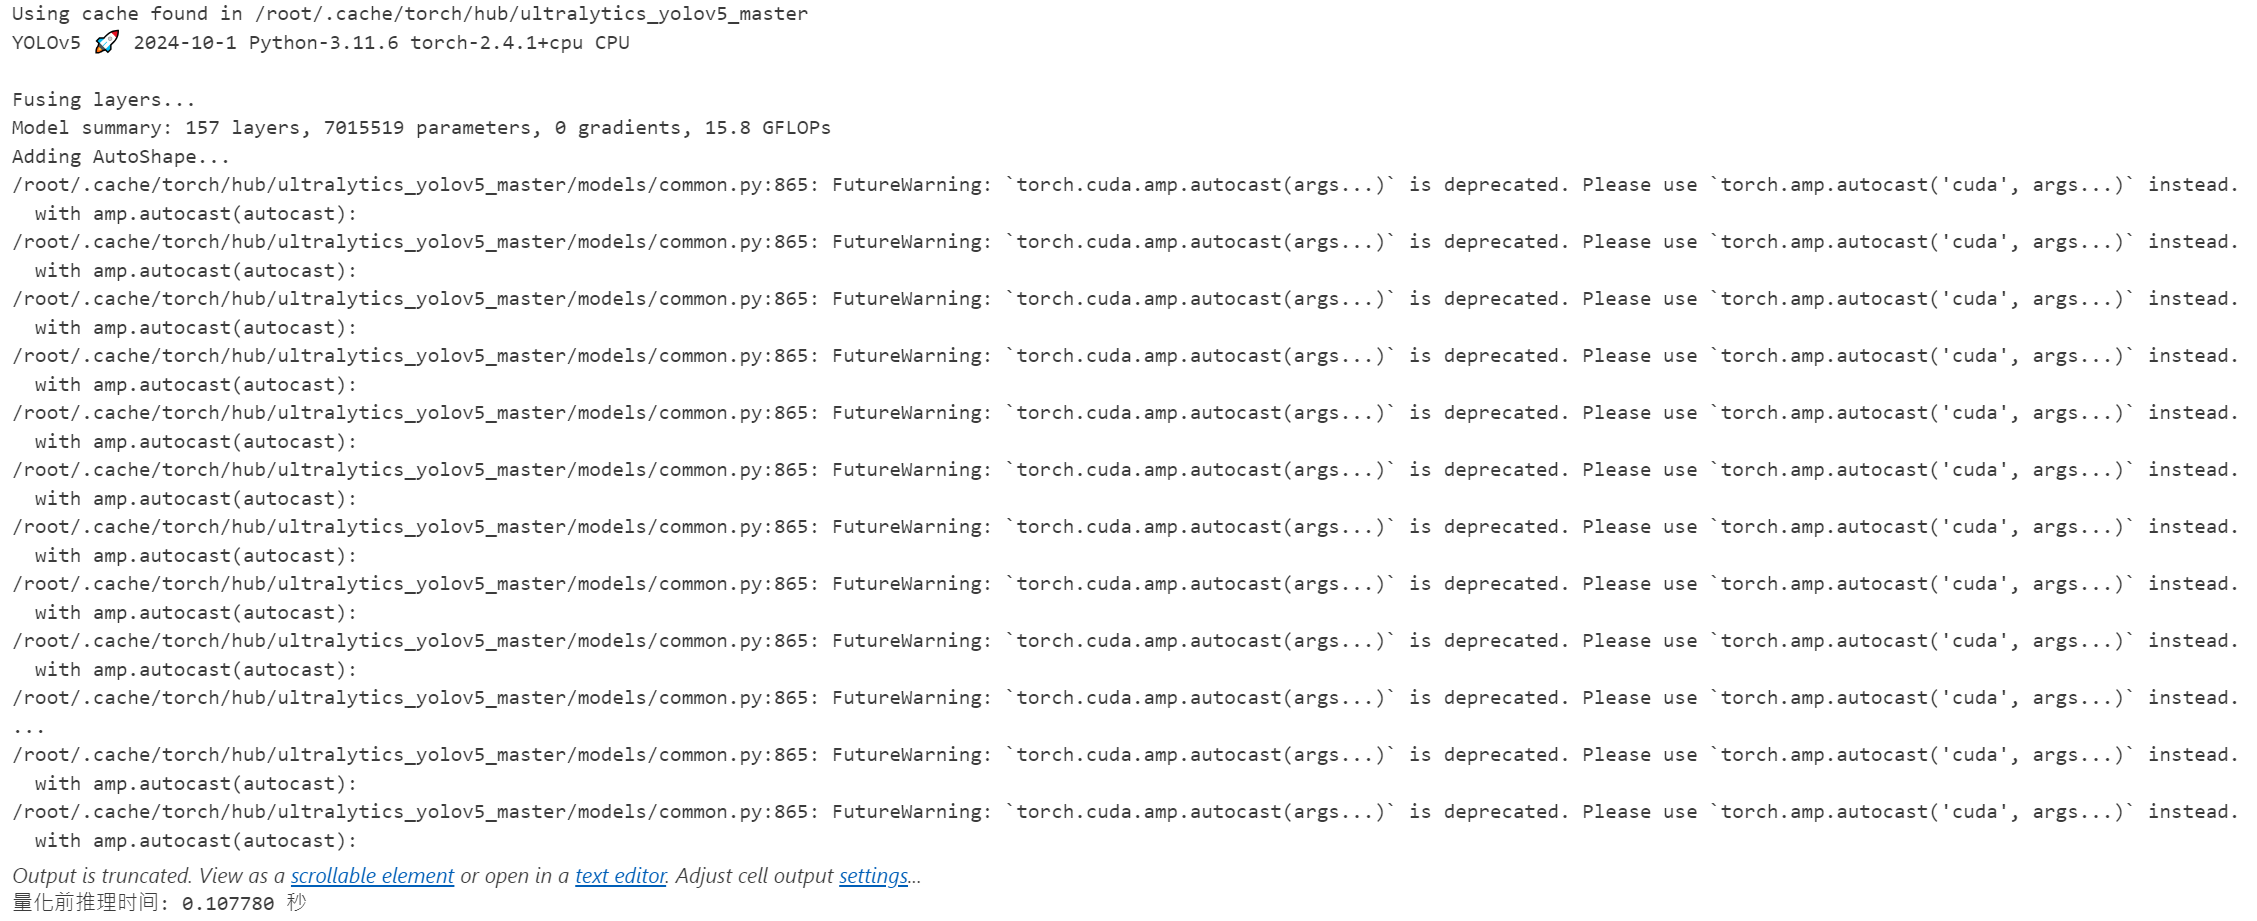

即約 0.11 秒。

#### 2. 量化後的推理時間和效能測驗：

In [ ]:
import torch
import time

# 定義一個函數來測試模型的推理時間
def test_inference_time(model, img, iterations=100):
    start_time = time.time()  # 記錄開始時間
    with torch.no_grad():  # 禁止梯度計算來加速推理
        for _ in range(iterations):  # 假設我們測試 100 次推理
            _ = model(img)  # 進行推理
    end_time = time.time()  # 記錄結束時間
    return (end_time - start_time) / iterations  # 計算平均推理時間

# 模擬一張 640x640 大小的隨機圖像
img = torch.randn(1, 3, 640, 640)

# 建立模型結構，並加載剪枝後的權重
model = torch.hub.load('ultralytics/yolov5', 'custom', path=r'/app/yolov5-master/runs/train/exp2/weights/best.pt')
model.load_state_dict(torch.load('/app/yolov5-master/pruned_model.pth'))  # 加載剪枝後的權重
model.eval()  # 設定模型為評估模式

# 測試模型的推理時間
quantized_model = torch.quantization.quantize_dynamic(
    model,  # 要量化的模型
    {torch.nn.Linear},  # 要量化的層類型
    dtype=torch.qint8  # 量化的數據類型
)

# 測試量化後的推理時間
inference_time_after = test_inference_time(quantized_model, img)

# 輸出結果
print(f"量化後推理時間: {inference_time_after:.6f} 秒")


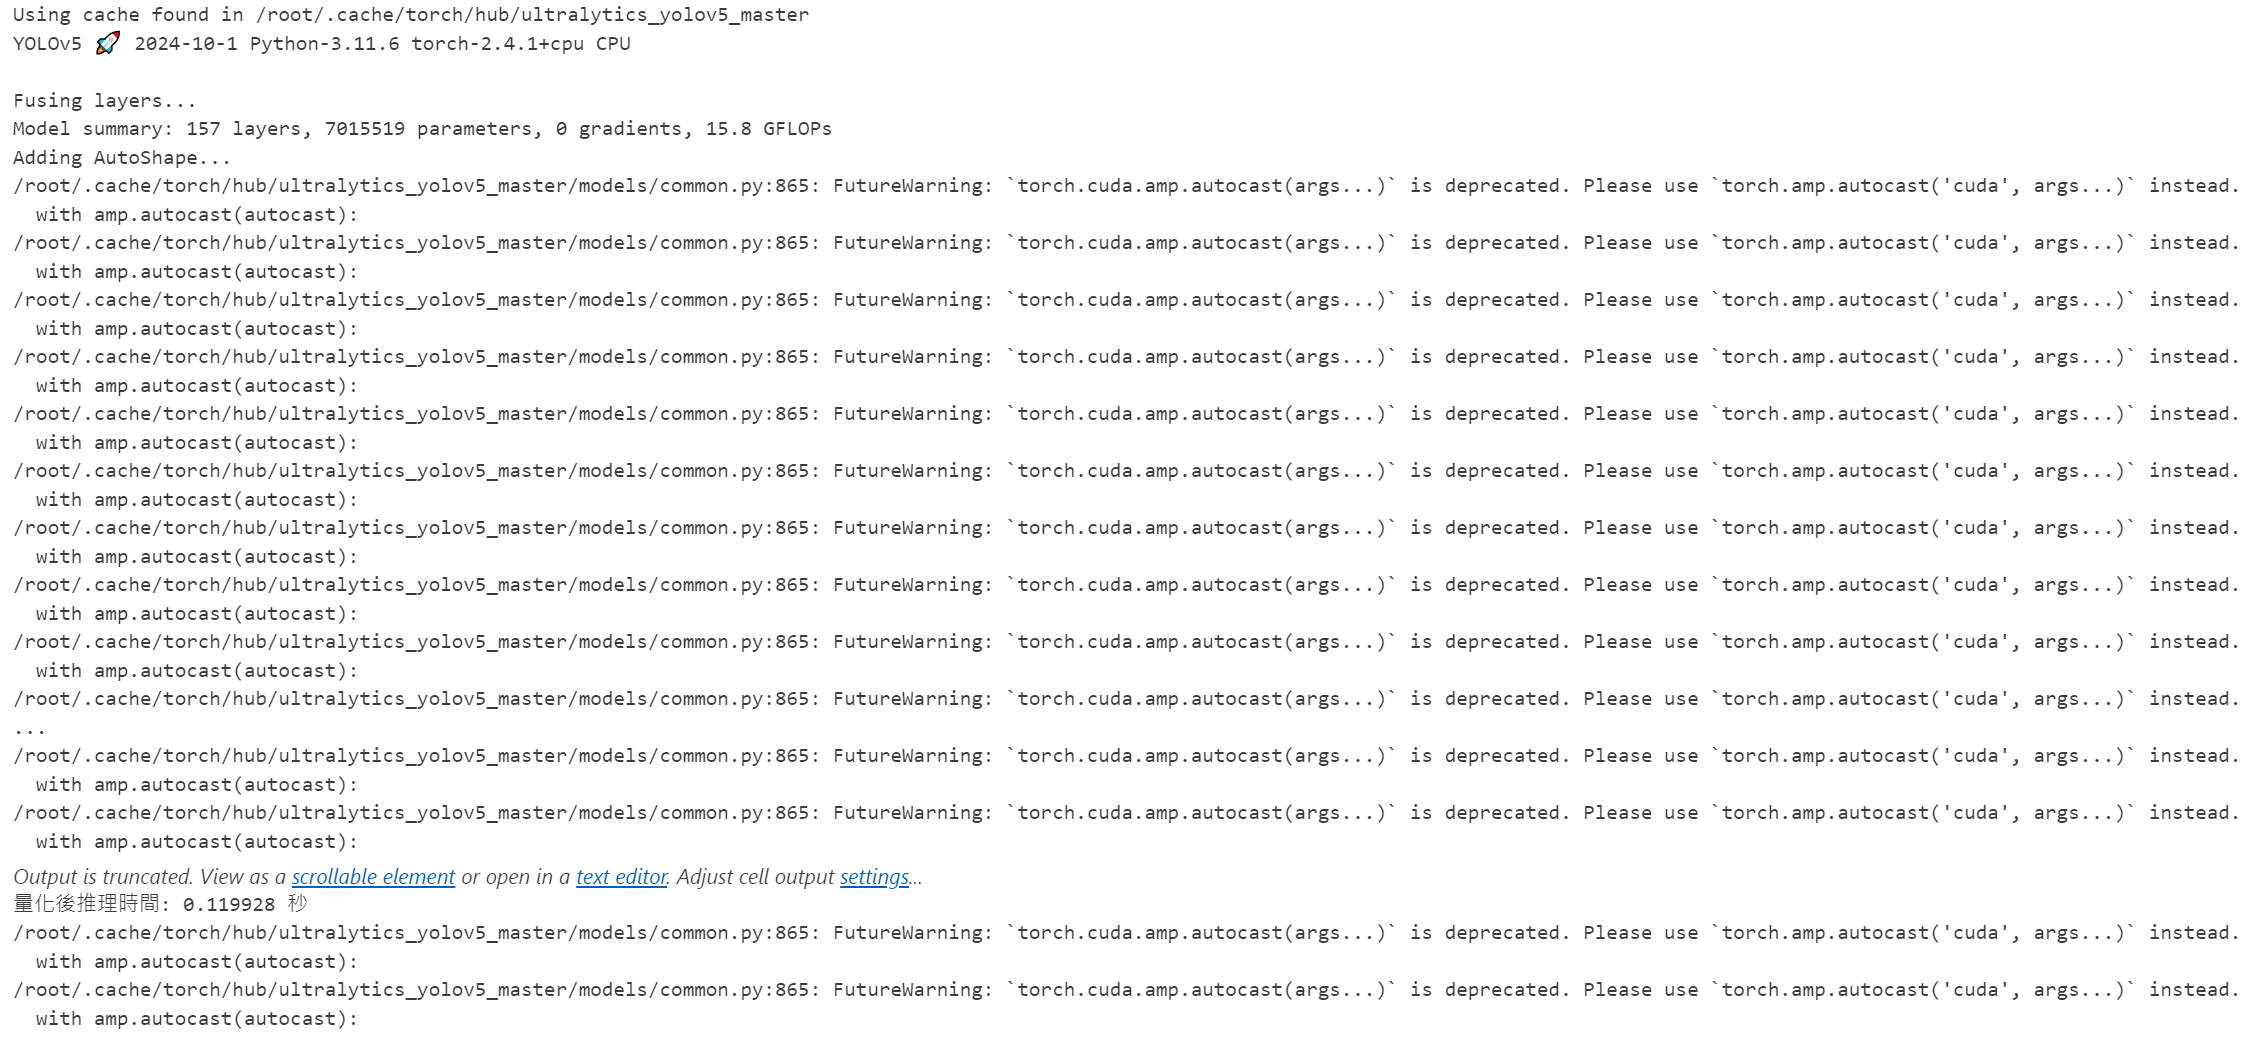

即約 0.12 秒。

**為什麼要進行量化？**
量化的目的是減少模型的計算成本和內存佔用，同時在保持合理準確率的情況下加速推理。量化技術特別適合應用於資源受限的環境（例如移動設備或嵌入式系統），這樣可以在保持模型性能的前提下大幅減少模型的資源需求。

---

### 第四步：混合精度訓練（Mixed Precision Training）

**混合精度訓練** 是一種通過將浮點數計算混合使用 **32 位（FP32）** 和 **16 位（FP16）** 浮點數的技術來提高訓練效率的方法。這種技術特別適合使用 GPU 訓練大型深度學習模型，因為它能減少計算負擔並加速訓練過程，同時節省記憶體。

#### 為什麼使用混合精度訓練？
1. **加速訓練速度：** 通過使用 FP16（16 位浮點數），計算的精度略微降低，但速度明顯加快，尤其在 GPU 上進行的計算中效果更為顯著。
2. **降低記憶體佔用：** 由於 FP16 佔用的記憶體比 FP32 小，可以在同樣的記憶體資源下訓練更大的模型或使用更大的 batch size。
3. **保持數值穩定性：** 混合精度訓練仍然保留部分關鍵操作的 FP32 精度來避免數值溢出或精度下降，這意味著在加速的同時仍保持模型的數值穩定。

#### 如何實現混合精度訓練？
PyTorch 提供了 **`torch.cuda.amp`**（自動混合精度）這個工具來輕鬆實現混合精度訓練。下面是實現步驟：

### 1. 訓練前準備

確保你有合適的 GPU 環境，因為混合精度訓練通常需要支援 **NVIDIA Tensor Cores** 的硬體設備。

### 2. 修改訓練循環
在你的訓練循環中引入 `torch.cuda.amp.autocast()` 和 `GradScaler` 來實現自動混合精度。

#### 關鍵步驟解釋：
1. **`autocast()`**：這是一個上下文管理器，在它的作用範圍內，模型的前向傳播會自動切換到適合的精度（FP16 或 FP32），以獲得更高的運算效率。
2. **`GradScaler`**：用來縮放損失並防止在 FP16 計算中可能出現的數值溢出。`GradScaler` 會根據每一步的損失自動調整縮放因子，並在必要時調整計算精度。

#### 示例程式碼：

In [ ]:
import torch

# 檢查 CUDA 是否可用
cuda_available = torch.cuda.is_available()

print(f"CUDA 是否可用: {cuda_available}")

# 如果 CUDA 可用，還可以檢查當前 GPU 設備
if cuda_available:
    print(f"可用的 GPU 數量: {torch.cuda.device_count()}")
    print(f"GPU 名稱: {torch.cuda.get_device_name(torch.cuda.current_device())}")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torchvision import models

# 加載 ResNet18 模型
model = models.resnet18(pretrained=True)  # 使用 ResNet18 作為示例模型進行實驗
model.fc = nn.Linear(model.fc.in_features, 2)  # 假設進行二分類任務
model = model.cuda()  # 將模型移動到 GPU 上

# 優化器和損失函數
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

# 創建 GradScaler 用來縮放梯度
scaler = GradScaler()

# 模擬的訓練循環
num_epochs = 10  # 假設 10 個 epoch
train_loader = [(torch.randn(8, 3, 224, 224), torch.randint(0, 2, (8,))) for _ in range(100)]  # 模擬的數據加載器，適應 ResNet18 的輸入大小

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()  # 將輸入和標籤移動到 GPU 上

        # 前向傳播，開啟 autocast 來進行混合精度計算
        with autocast():  # 啟動自動混合精度
            outputs = model(inputs)  # 前向傳播
            loss = loss_fn(outputs, labels)  # 計算損失

        # 反向傳播和優化，使用 GradScaler
        scaler.scale(loss).backward()  # 縮放損失值並計算梯度
        scaler.step(optimizer)  # 更新模型參數
        scaler.update()  # 更新 scaler

        # 清空梯度
        optimizer.zero_grad()  # 清空上一次迭代的梯度

    print(f"Epoch {epoch} finished")

使用 PyTorch 的 `torch.save()` 函數來保存訓練後的模型權重。通常我們會保存兩種類型的檔案：

1. **僅保存模型的參數（權重）**：這是最常見的保存方式，適合之後在相同模型結構下進行推理或繼續訓練。
2. **保存整個模型**：這包括模型的架構和權重，適合在不再定義模型架構的情況下重用。

### 1. 保存模型權重

你可以使用 `torch.save()` 將模型的權重保存到指定的檔案路徑。以下是具體的程式碼：

In [ ]:
import os
import torch

save_dir = r'/app/30-Day_AI_Deep_Learning_Plan'
os.makedirs(save_dir, exist_ok=True)  # 如果路徑不存在則創建它

# 保存訓練好的模型
save_path = os.path.join(save_dir, 'Day28_trained_resnet18.pth')
torch.save(model.state_dict(), save_path)
print(f"模型已保存到 {save_path}")

### **測試模型的推理時間(不使用混合精度)**

In [ ]:
import torch
import torch.nn as nn
import time
from torchvision import models

# 加載 ResNet18 模型
model = models.resnet18(pretrained=True)  # 使用 ResNet18 作為示例模型
model = model.cuda()  # 將模型移動到 GPU 上

# 模型切換到評估模式（推理模式）
model.eval()

# 模擬一些輸入資料
inputs = torch.randn(16, 3, 1920, 1080).cuda()  # 模擬一批 1920x1080 大小的圖像 (16 張)

# 測試推理時間
iterations = 100  # 測試推理的次數
start_time = time.time()

# 在推理過程中不需要計算梯度，不使用混合精度推理
with torch.no_grad():
    for _ in range(iterations):
        outputs = model(inputs)  # 直接進行推理，無需 autocast

end_time = time.time()

# 計算平均推理時間
average_inference_time = (end_time - start_time) / iterations
print(f"ResNet18 模型的平均推理時間: {average_inference_time:.6f} 秒")

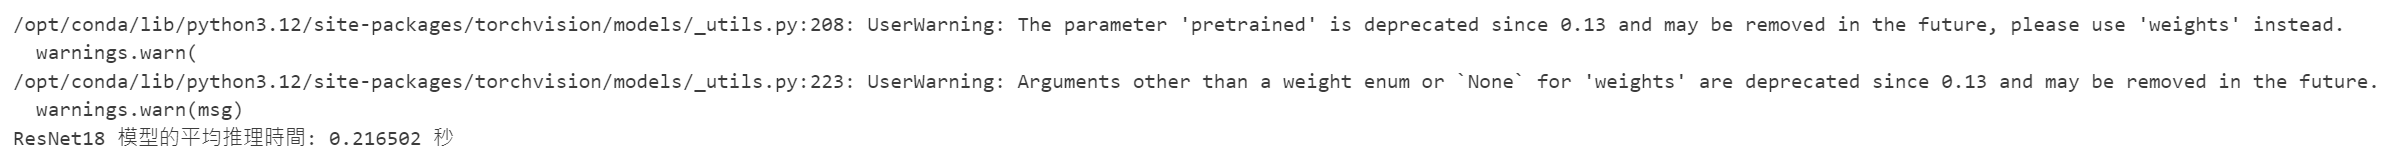

### **測試模型的推理時間(使用混合精度)**

In [ ]:
import torch
import torch.nn as nn
import time
from torch.cuda.amp import autocast
from torchvision import models

# 加載 ResNet18 模型
model = models.resnet18(pretrained=True)  # 使用 ResNet18 作為示例模型
model.fc = nn.Linear(model.fc.in_features, 2)  # 假設進行二分類任務
model.load_state_dict(torch.load('/app/weights/Day28_trained_resnet18.pth'))  # 加載訓練好的模型權重
model = model.cuda()  # 將模型移動到 GPU 上

# 模型切換到評估模式（推理模式）
model.eval()

# 模擬一些輸入資料
inputs = torch.randn(16, 3, 1920, 1080).cuda()  # 模擬一批 1920x1080 大小的圖像 (16 張)

# 測試推理時間
iterations = 100  # 測試推理的次數
start_time = time.time()

# 在推理過程中不需要計算梯度，使用混合精度推理
with torch.no_grad():
    for _ in range(iterations):
        with autocast():  # 使用混合精度來加速推理
            outputs = model(inputs)  # 進行推理

end_time = time.time()

# 計算平均推理時間
average_inference_time = (end_time - start_time) / iterations
print(f"使用混合精度的 ResNet18 模型平均推理時間: {average_inference_time:.6f} 秒")

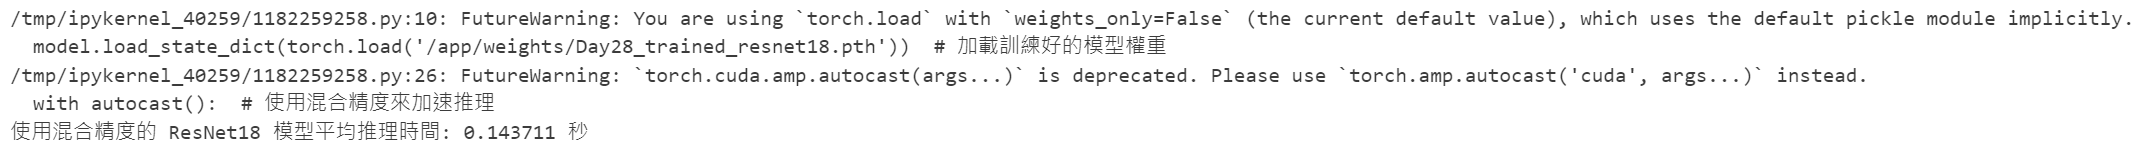

剛剛在測試 ResNet18 的推理時間（不使用混合精度）時，不需要 `model.fc = nn.Linear(model.fc.in_features, 2)` 是因為我們只是加載了預訓練的 ResNet18 模型，並直接用於推理，而不是針對特定任務進行訓練或調整。

### 1.預訓練模型的輸出層
- 在不使用 `model.fc = nn.Linear(...)` 的情況下，我們加載了 PyTorch 提供的預訓練模型（ResNet18）。這個模型的輸出層對應於 ImageNet 上的 1000 類分類，因此輸出是一個形狀為 `(batch_size, 1000)` 的張量。
- 如果只是測試模型的推理時間，我們可以忽略輸出是針對什麼類別的，因此直接使用預設的輸出層就可以。

### 2.調整輸出層的情況
- 在訓練過程中，我們通常需要調整輸出層以適應特定的任務。例如，如果我們希望 ResNet18 用於二分類任務，就需要修改輸出層，使得它輸出兩個類別，而不是原始的 1000 個類別。
- 在訓練 ResNet18 的代碼中，使用了 `model.fc = nn.Linear(model.fc.in_features, 2)`，這樣就適配了二分類的需要。

### 總結
- **不使用混合精度的推理測試**：只需測試推理性能，不涉及特定的分類任務，可以直接使用預訓練模型。
- **使用混合精度推理且使用訓練好的模型權重**：需要確保模型結構與訓練時相同，因此需要修改輸出層，使其與訓練過程一致。
- **如果你想要讓模型的輸出層與最初的 ResNet18 模型相同，那麼需要將輸出層的單元數改回 1000，這樣就能夠與原始的 ImageNet 上的預訓練模型保持一致。**

```python
model.fc = nn.Linear(model.fc.in_features, 1000)  # 恢復到原始的 1000 類別輸出
```

---

### 4. 優化效果觀察
- **訓練速度提升：** 在大型資料集或模型上，混合精度能顯著減少訓練時間，特別是在使用 GPU 訓練時。
- **節省記憶體：** FP16 會減少所需記憶體，這讓你可以使用更大的 batch size 或訓練更複雜的模型。
- **模型準確率保持穩定：** 雖然使用了較低精度的 FP16，但透過保留關鍵計算（如權重更新）在 FP32 下進行，模型的準確性應該不會顯著下降。

測試結果顯示：
- 不使用混合精度推理的平均時間為 **0.216 秒**。
- 使用混合精度推理的平均時間為 **0.143 秒**。

這顯示混合精度推理有顯著的加速效果，大約提升了 **35%** 左右的效率。

### 為什麼混合精度推理更快？
以下是混合精度推理提升推理速度的幾個原因：
1. **減少數據量**：
   - 使用混合精度會將部分計算（例如張量的乘積）從 32 位浮點數（FP32）轉為 16 位浮點數（FP16），這樣可以大幅減少需要處理的數據量。
  
2. **更高的 GPU 計算效率**：
   - 許多現代 GPU（例如 NVIDIA 的 Ampere 或 Volta 架構）包含針對 FP16 計算的硬體加速器（如 Tensor Cores），它們能夠高效地執行混合精度的計算，並且比純 FP32 計算更快。
  
3. **更高的記憶體帶寬利用率**：
   - FP16 需要的記憶體空間較少，因此能減少內存帶寬壓力，允許更快地加載更多數據來進行計算。

### 總結
- **推理性能提升**：你的結果顯示，使用混合精度推理能有效地提升 ResNet18 模型的推理速度，從 0.22 秒下降到 0.14 秒。
- **適用情景**：這種加速在模型推理中尤為顯著，尤其適用於在部署中對延遲敏感的應用，比如實時影像處理或在線推理服務。

混合精度推理是一種非常有效的方式來平衡精度與性能，特別是在 GPU 支援混合精度計算的情況下。你可以考慮在部署中使用混合精度來提升性能，同時不會對模型的準確性有太大影響。

恭喜你完成了「模型優化與效能提升」的課程！從剪枝、量化到混合精度訓練，你已經掌握了各種提升模型效能的技術。

---